In [1]:
import os
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.special import logsumexp
from tqdm import tqdm
import emcee
import corner

from astropy import units as u 
from astropy.table import Table
from math import *

from snewpy.neutrino import ThreeFlavor, MassHierarchy, MixingParameters, ThreeFlavorMixingParameters,FourFlavorMixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.models.ccsn import Zha_2021
from snewpy.models.ccsn import Tamborra_2014
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes
#from asteria import set_rcparams
from asteria.simulation import Simulation

%matplotlib inline

ha


In [2]:
sukh_param_sfho=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='SFHo')
sukh_param_ls220=list(params for params in Sukhbold_2015.get_param_combinations() if params['progenitor_mass'].value == 27 
                      and params['eos']=='LS220')


forn_param=list(params for params in Fornax_2022.get_param_combinations() if params['progenitor_mass'].value == 26.99)

zha_param=list(params for params in Zha_2021.get_param_combinations() if params['progenitor_mass'].value == 26)

tamb_param=list(params for params in Tamborra_2014.get_param_combinations() if params['progenitor_mass'].value == 27
               and params['direction']==1)

In [3]:
sukh_model_sfho = {'name': 'Sukhbold_2015',
            'param': sukh_param_sfho[0]
              }

sukh_model_ls220 = {'name': 'Sukhbold_2015',
            'param': sukh_param_ls220[0]
              }

forn_model = {'name': 'Fornax_2022',
            'param': forn_param[0]
              }

zha_model = {'name': 'Zha_2021',
            'param': zha_param[0]
              }

tamb_model = {'name': 'Tamborra_2014',
            'param': tamb_param[0]
              }

In [4]:
models=[sukh_model_sfho,sukh_model_ls220,forn_model,zha_model,tamb_model]
model_orignals=[Sukhbold_2015,Sukhbold_2015,Fornax_2022,Zha_2021,Tamborra_2014]
labels=['nmo','imo']
hie=['normal','inverted']
mod_names=['sukh_sfho','sukh_ls220','forn','zha','tamb']

sims = {
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
}

for i,mod in enumerate(models):
    for j,lab in enumerate(labels):
        if mod['name']=='Fornax_2022':
            with open("ThreeFlavor_{}_M={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                    lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))
        else:
            with open("Three_Flavor_{}_M={}_eos={}_mix={}.pkl".format(mod['name'], mod['param']['progenitor_mass'].value,
                                                        mod['param']['eos'],
                                                        lab), 'rb') as f:
                sims[mod_names[i]].append(pickle.load(f))

In [5]:
def compute_hits(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
        
    data=hits[id5:id6]
    return data

In [6]:
def compute_hits_without_sub_bg(dist,dt,start,end,sim):
    sim.rebin_result(dt)
    sim.scale_result(dist)
    t, hits = sim.detector_signal(dt)
    bg1 = sim.detector.i3_bg(dt,size=hits.size) + sim.detector.dc_bg(dt,size=hits.size)
    sig=bg1+hits
    id5=np.where(t==start)[0][0]
    id6=np.where(t==end)[0][0]
    
    return sig[id5:id6]

In [7]:
def log_prob_poisson(theta, model_hits, data_hits,betamin, betamax, bmin, bmax):
    beta,bg=theta
    
    if bmin <= bg <= bmax and betamin <= beta <= betamax:
        log_prior = np.log(1/(betamax-betamin)*1/(bmax-bmin))
        return log_likelihood_poisson(bg, beta, model_hits, data_hits) + log_prior
    
    return -np.inf 

In [8]:
def log_likelihood_poisson(bg,scale,model_hits,data_hits):
    result=0
    for i in range(len(model_hits)):
        result+=data_hits[i]*np.log(bg+scale*model_hits[i])-bg-scale*model_hits[i]-lgamma(data_hits[i]+1)
    return result

In [11]:
def compute_log_integral(data_hits,model_sim,dist,dt):
    model_hits=compute_hits(dist,dt,-.5*u.s,.46*u.s,model_sim)
    
    betamin=0
    betamax=30000/np.max(model_hits)
    
    self=model_sim.detector
    bg_mean= self.i3_dom_bg_mu * dt.to(u.s).value * self.n_i3_doms + self.dc_dom_bg_mu * dt.to(u.s).value * self.n_dc_doms
    bg_var= (self.i3_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_i3_doms))**2 + (self.dc_dom_bg_sig * np.sqrt(dt.to(u.s).value * self.n_dc_doms))**2
    bg_sig=np.sqrt(bg_var)
    
    bmin= bg_mean-3*bg_sig
    bmax= bg_mean+3*bg_sig
    
    ndim = 2
    nwalkers = 32
    
    bminguess= bg_mean-1*bg_sig
    bmaxguess= bg_mean+1*bg_sig

    initial_positions = np.random.uniform([betamin, bminguess], [betamax, bmaxguess], (nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_poisson, args=(model_hits, data_hits, betamin, betamax, bmin, bmax))

    nsteps = 1000
    sampler.run_mcmc(initial_positions, nsteps)

    burn_in = 100
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    logprob=[log_prob_poisson((beta,b), model_hits, data_hits, betamin, betamax, bmin, bmax) for beta,b in samples]
    print(logprob[:10])
    
    bs=samples[:,0]
    betas=samples[:,1]
    integration_area=(np.max(bs)-np.min(bs))*(np.max(betas)-np.min(betas))
    logint=np.log(integration_area/len(samples[:,0]))+logsumexp(logprob)

    return logint

In [13]:
def log_probs_with_poisson_mult_priors(data_sim,model_sims,priors,dist,dt,hierarchy,errs):
    log_ratios=[]
    for j in tqdm(range(errs)):
        data_hits=compute_hits_without_sub_bg(dist,dt,-.5*u.s,.46*u.s,data_sim)
        log_prob_nh=[]
        log_prob_ih=[]
        log_ratio=[]
        for k,name in enumerate(model_sims.keys()):
            log_p_d_nh=compute_log_integral(data_hits,model_sims[name][0],dist,dt)
            log_p_d_ih=compute_log_integral(data_hits,model_sims[name][1],dist,dt)
            log_prob_nh.append(log_p_d_nh)
            log_prob_ih.append(log_p_d_ih)
 
        for i,prior in enumerate(priors):   
            p_nh=[]
            p_ih=[]
            for k,pro in enumerate(log_prob_nh):
                log_p_d_nh=pro
                log_p_d_ih=log_prob_ih[k]
                
                p_nh.append(log_p_d_nh-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))
                p_ih.append(log_p_d_ih-logsumexp([log_p_d_nh,log_p_d_ih])+np.log(prior[k]))

            prob_nh=logsumexp(p_nh)
            prob_ih=logsumexp(p_ih)
            
            if(hierarchy==0):
                log_ratio.append(prob_nh-prob_ih)
            else:
                log_ratio.append(prob_ih-prob_nh)
        log_ratios.append(log_ratio)
            
    return log_ratios

In [22]:
prior_list=np.linspace(.2,.99,100)

ratios_ih={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }

for i,mod_name in enumerate(ratios_ih.keys()):
    all_priors=[]
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        all_priors.append(priors)
    mod_ratios=log_probs_with_poisson_mult_priors(sims[mod_name][1],sims,all_priors,10*u.kpc,10*u.ms,hierarchy=1,errs=1)
    ratios_ih[mod_name].append(mod_ratios)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-959.6872054401433, -957.507351851757, -957.8588943127511, -957.9830233407379, -957.9972172477542, -957.5433434306146, -957.9346829106621, -957.864140471906, -957.5292130170242, -957.7487166483011]
[-660.7968010298961, -660.4536746573891, -660.2771741165076, -661.5649916757853, -660.8935787283577, -660.1498308109173, -660.6326625041571, -660.2637724916445, -662.9900249669469, -663.0356461861544]
[-1234.3165703701618, -1234.6756954470131, -1234.4007569453045, -1234.6325228947628, -1235.3563440305536, -1235.4864091187576, -1237.661183833867, -1235.7639245197736, -1235.7474692756607, -1235.2472942250263]
[-755.5502121911715, -759.5901074746372, -755.7115358700258, -756.4714956960389, -755.8360864383004, -755.816242405782, -757.891217495243, -756.2062168697167, -755.700206464143, -757.225963861246]
[-1679.2288547939995, -1680.8445356370673, -1681.687398280951, -1680.5454756445713, -1679.2707081385622, -1679.8322642764422, -1679.589176265278, -1679.879468466667, -1679.1426696772567, -1680.

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:53<00:00, 233.61s/it]


[-928.6020077021636, -929.8041761384771, -930.6022989483569, -931.3960680541019, -930.2371488870373, -929.8891315450561, -929.0442139570038, -929.0744236975985, -929.1742752157985, -929.5263806621912]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-934.6663685942444, -934.4886519837278, -934.4595901475955, -934.4268903487796, -934.9849486230491, -934.909081801798, -934.492000685827, -935.181992390088, -935.0321381663057, -934.6425262773378]
[-780.5745412880229, -780.1739308836428, -781.02955712598, -780.5256732415897, -780.4853422524926, -782.2631079224399, -781.3370002990001, -781.3039730995685, -781.3917285594677, -780.6466609029764]
[-1111.4228637847211, -1110.9641761001642, -1110.9614656629658, -1111.1053251260403, -1110.520006941306, -1110.923782637847, -1110.978050918575, -1112.3083671157167, -1110.8584766534425, -1113.6599155437527]
[-660.5245110881525, -659.8579257436078, -661.5749441795352, -660.1688965638469, -659.2202832967897, -659.1879612593049, -659.9958087407878, -660.1137153757601, -660.0066868797741, -658.9125352522252]
[-2070.9648045021195, -2070.472276142408, -2069.7484160349877, -2070.490734777707, -2069.921557349214, -2069.9903939122332, -2070.2634050228835, -2071.3752075871625, -2070.2611476653283, -2070.0

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:54<00:00, 234.12s/it]


[-1061.0009606064227, -1060.5889455324464, -1061.625942978029, -1060.6101409625512, -1063.283689265499, -1065.09071112626, -1060.8440370539133, -1062.2075838905835, -1061.213610696646, -1061.4868107035977]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1929.2060288339676, -1928.4237265148226, -1929.057652559492, -1929.277694381843, -1928.547197764518, -1928.0182048086976, -1930.1965644432462, -1928.0628603527698, -1928.0530057891997, -1928.741345835832]
[-2083.036995424062, -2082.9801826448843, -2082.945433464806, -2087.059822334066, -2083.3293917098804, -2083.2522414235013, -2084.935044329412, -2083.0405668584303, -2082.9394373457785, -2083.4399096125585]
[-2570.418210004538, -2571.6722001117396, -2572.586260033926, -2571.1935720171405, -2570.3286925639204, -2571.2584228546857, -2572.0398386346005, -2570.965121551513, -2570.519073042562, -2571.310826303563]
[-2846.7612112303477, -2846.7371343886343, -2847.472121427666, -2847.2773954687445, -2847.663584982526, -2846.6292761753148, -2848.0614156358797, -2846.9472447923335, -2847.2410910178014, -2847.331971722845]
[-1277.599327695151, -1277.8227250588268, -1280.08355140647, -1279.184438373634, -1278.1499511422178, -1279.8167182210334, -1279.519107398274, -1277.3368599409903, -1277.48

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:45<00:00, 285.70s/it]


[-1420.6257786079764, -1420.3672911582794, -1420.275211082811, -1422.480734649445, -1421.4405340886838, -1420.5872470974969, -1423.2007414867799, -1422.1030615814484, -1422.1140289580612, -1420.2467898507125]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1746.163161053712, -1743.4063208683187, -1742.487809734474, -1743.0697153853657, -1744.96753285758, -1742.061731925493, -1744.4097474951818, -1745.6560103179768, -1742.1719231326392, -1742.1549318845177]
[-1206.8297140086968, -1208.4876141909506, -1206.5798295050215, -1206.0881186197391, -1207.0430885460544, -1207.1829934018776, -1206.6980019822247, -1206.2037015593548, -1206.5670215297748, -1206.2592736494432]
[-2243.886759988187, -2243.6179971604815, -2243.0016793347986, -2243.2426372652644, -2242.3988905284004, -2241.7111771563887, -2241.916384950304, -2243.0486057679755, -2242.154333844601, -2241.960679356818]
[-1567.362752528993, -1567.8380332742681, -1566.524254247489, -1566.2525711715725, -1567.7723088021894, -1566.5906023381258, -1570.0187559202323, -1566.8869060677835, -1566.511332509327, -1566.2500060002503]
[-2166.596000363791, -2167.288264632519, -2165.9705785322612, -2166.6639128925335, -2166.1558248950923, -2165.863569245633, -2167.898536909156, -2165.951522198756, -216

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:56<00:00, 236.45s/it]


[-1403.8048517925013, -1404.5548688523518, -1402.5976556064957, -1402.8431545531453, -1402.6416684922692, -1402.651128461333, -1402.9478717812558, -1403.2168422005884, -1404.7476415367232, -1404.5319138442824]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-907.5912735020943, -907.6191062308758, -907.9608270314607, -907.7268883924376, -907.7965564549927, -907.8177600288586, -908.0316153965073, -909.4168699232364, -907.6366977982366, -908.1966682287571]
[-1178.130470738545, -1178.3387991845545, -1177.7948882101362, -1178.350306573763, -1179.0589038886271, -1178.4297808238214, -1178.6678789497407, -1181.0711087426487, -1177.8791815592292, -1177.8200251147816]
[-1287.3331596902083, -1287.4255962800619, -1288.8985717450798, -1286.496366267291, -1286.9085844245658, -1286.4111492267496, -1288.1454406325013, -1286.471134245696, -1287.5023430958047, -1290.272672502697]
[-1339.136405788552, -1340.0416141426404, -1339.4856866045748, -1340.1165155229837, -1339.4001364625738, -1339.3748558704692, -1339.3102002118258, -1339.751537107747, -1339.7725345608496, -1339.276958684496]
[-1328.5072882568081, -1328.8124193157007, -1327.2521934696003, -1330.419892239154, -1327.0140289518629, -1327.1984890656192, -1327.2134882844427, -1327.9220588994965, -1326.

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:35<00:00, 215.53s/it]

[-679.5709886224755, -676.3743303532061, -676.4181870403514, -676.8811751140271, -676.0926998604515, -676.6018679115765, -674.8909192650277, -675.0628066844325, -675.1131309321751, -676.8058275574255]


In [21]:
prior_list=np.linspace(.2,.99,100)

ratios_nh={
    'sukh_sfho': [],
    'sukh_ls220': [],
    'forn': [],
    'zha': [],
    'tamb': []
    }

for i,mod_name in enumerate(ratios_nh.keys()):
    all_priors=[]
    for j,prior in enumerate(prior_list):
        priors=[(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4,(1-prior)/4]
        priors[i]=prior
        all_priors.append(priors)
    mod_ratios=log_probs_with_poisson_mult_priors(sims[mod_name][0],sims,all_priors,10*u.kpc,10*u.ms,hierarchy=0,errs=1)
    ratios_nh[mod_name].append(mod_ratios)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-647.2438417372728, -647.3133865441891, -647.929563626702, -648.9756764100862, -647.9834495770451, -648.0558463566963, -647.5399617055341, -647.2377817414058, -648.1692866681374, -647.0782668966535]
[-894.1641651931592, -892.4229676744313, -893.3527884825331, -893.8601578795084, -892.4446292904346, -894.233959329055, -892.7101667693083, -892.4632751658816, -892.9364576838003, -893.412553261575]
[-798.0808729486691, -794.6500000161998, -794.4422818877158, -796.6422331038432, -794.9074779657333, -793.773114848382, -794.2694151651178, -794.8763042173034, -794.3518513053662, -794.0090491418034]
[-856.2958678948208, -856.8932941692048, -856.9031852781637, -856.5840080899662, -858.158662572766, -858.4265875583234, -856.5043702973936, -856.6730166818462, -857.0347735757542, -856.2781862296698]
[-1310.361980388249, -1309.5027296681972, -1311.3964026961937, -1309.4988897288592, -1310.3099026081643, -1308.7736292334764, -1308.408037434873, -1308.6157062267328, -1311.5915637820024, -1309.3600110

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:38<00:00, 158.95s/it]


[-761.8260354798655, -761.8413724365197, -761.5674980546424, -761.950764165285, -762.0836936393422, -762.1971161494981, -761.663254972165, -761.3360800538172, -762.4269739852713, -761.3322326175654]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-798.5386907469042, -798.2855946071618, -798.8931696174518, -800.1669763105278, -802.2336494344895, -798.5880710062452, -798.4344923425638, -800.4281941190534, -801.473360984161, -798.3334313143537]
[-1507.0069453843632, -1507.3462067954995, -1508.2837582060044, -1508.4153915233207, -1507.9342079141377, -1507.6430765429566, -1507.5142790547277, -1509.958857249602, -1510.5425135578432, -1507.1297943070992]
[-664.2083907433355, -666.8890067255654, -664.2317876360851, -664.3605586811848, -664.0271168345882, -664.8674082142481, -665.5341906212363, -663.7111508822657, -665.2286107464263, -663.7132914257329]
[-1230.966034084894, -1230.7370745990202, -1230.5467482811518, -1230.7676592009675, -1231.0919472260148, -1230.4169206936795, -1231.4689386553664, -1231.8365805384974, -1232.7751993173742, -1230.5557632809805]
[-1652.9769393442136, -1652.378406025268, -1652.6206138111036, -1655.1997230365403, -1652.7349684426179, -1653.1975105931658, -1652.653396265249, -1654.6678679457425, -1653.949904

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:48<00:00, 168.94s/it]


[-1162.2875525274535, -1163.5251226785726, -1162.4717030747083, -1163.5201128863368, -1163.2769774496078, -1164.1882687017892, -1162.5031778312073, -1164.3623538463685, -1163.5893917798635, -1162.4378287529648]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-2834.4259045069016, -2833.9156842555353, -2833.5690272562465, -2835.888152068856, -2833.733044392528, -2833.718600893317, -2835.543400028659, -2835.0212587728424, -2833.7426834624753, -2838.5775034220683]
[-4599.775143833979, -4600.932665559801, -4599.101698897607, -4601.183343348198, -4599.314326811585, -4598.913248783839, -4599.273677617678, -4598.802442212403, -4599.19717209526, -4598.974412592727]
[-3305.8581655653343, -3307.3470109825957, -3306.039949458829, -3307.5870477916997, -3306.4884477690593, -3305.8213283933965, -3306.1470697764107, -3309.790068351833, -3306.617488140948, -3306.1282004709155]
[-5375.058518884428, -5374.703949930336, -5374.479621004474, -5376.726948523793, -5374.358979712838, -5374.519412047056, -5375.116895080778, -5376.47946431175, -5374.9197366250455, -5375.672124825535]
[-650.9594032577613, -653.0422971250398, -651.0452210179817, -655.9736623755623, -652.8100255937923, -651.0294368572238, -651.019865776633, -651.0010968680751, -650.7722010724999, -651

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [38:10<00:00, 2290.08s/it]


[-2154.2594248569035, -2156.644104837858, -2154.3614430438133, -2157.3253051778697, -2155.3816424199426, -2155.568608050187, -2154.7914487902704, -2154.3545912782533, -2156.6272839034605, -2155.5451685134135]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-4960.847871387636, -4959.625024586985, -4958.6579057988965, -4958.945021017378, -4958.64464883941, -4959.067943412443, -4958.6582301616545, -4962.631342457938, -4958.446563572328, -4958.5464519108755]
[-7309.651432293877, -7309.720968414988, -7310.4897761068305, -7309.378415517148, -7309.375340490532, -7309.750486691791, -7309.591594304601, -7309.514927479936, -7309.566189753928, -7309.80254215599]
[-4941.2412594330035, -4939.745364329045, -4941.152112868871, -4940.890583308525, -4939.838506477763, -4941.044466766669, -4940.439096821554, -4940.135100964233, -4939.899759146074, -4940.566314237318]
[-7996.690654168998, -7996.689014115794, -7996.794571115738, -7997.611030624846, -7996.666581179642, -7996.511812843136, -7996.981935505465, -7998.362427646935, -7996.57634915301, -7997.452780272332]
[-1847.6314313547798, -1844.6408012260097, -1845.6254023343815, -1844.9306449494932, -1844.7513998518723, -1844.3852158744146, -1844.4038345755569, -1844.3386538875227, -1845.2270056626173, -184

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:38<00:00, 218.67s/it]


[-4674.870659076227, -4674.089910648192, -4673.123158002007, -4672.630113267482, -4672.030879169277, -4672.127402384165, -4672.087755476092, -4672.9576994509225, -4673.312422342522, -4673.139277747552]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

[-1225.7309773473066, -1222.8418624057053, -1221.3071062034837, -1222.1185720757608, -1221.3738996577417, -1222.0491508817327, -1221.549890350227, -1222.5674680811612, -1221.4577603268376, -1221.907131340759]
[-2390.2965249359427, -2390.274753215114, -2390.234517118823, -2390.6559121254563, -2390.532446831205, -2390.336747242984, -2391.9928841220994, -2392.581023696114, -2392.06466058882, -2392.552016069358]
[-1479.7474742534052, -1479.0629229026474, -1479.6702212783805, -1479.3267480921734, -1479.0104333393049, -1479.3879299177154, -1479.815461413071, -1479.8476540615177, -1478.9455708127155, -1479.4558065465483]
[-2472.4639442533235, -2472.7973693579415, -2471.7523059126115, -2472.6846327908142, -2471.3532061684537, -2472.7412062707745, -2471.8649969980625, -2473.117429296851, -2471.387383012975, -2471.3520362232093]
[-1204.2138968793322, -1204.6745584612243, -1204.1057873411944, -1204.9631078930422, -1204.4514593249212, -1204.6032160197235, -1205.833345449212, -1204.343772554991, -1

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [03:58<00:00, 238.62s/it]

[-1008.8330900305697, -1010.0117529958476, -1008.5787127865875, -1009.5567153152475, -1011.5949079203816, -1009.0127913697321, -1010.5320201520041, -1010.7191280361836, -1010.6071267956974, -1008.9127277261974]


In [32]:
compute_log_integral(data_hits,sims['sukh_sfho'][0],5*u.kpc,10*u.ms)

[-823.0358047519582, -822.9687712312185, -821.2421364946819, -821.2961312743024, -821.0196896563317, -822.8969512662912, -821.6965678648882, -821.1824708493256, -821.9124961085214, -821.4502586835621]


-821.0507217271572

In [26]:
np.savez('ratios_many_priors_nh',ratios_nh)
np.savez('ratios_many_priors_ih',ratios_ih)

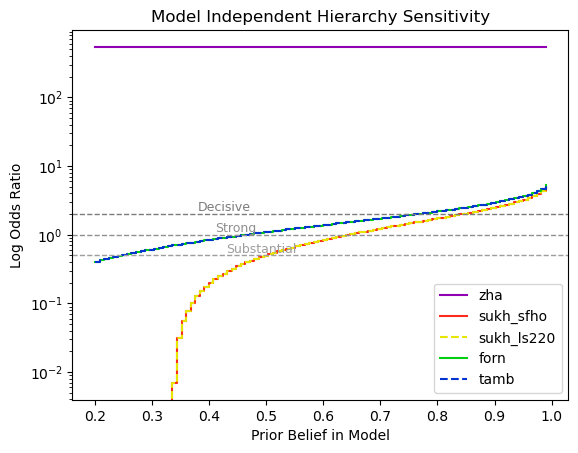

In [25]:
colors=['#9200b3','#fc2b1c','#e6e602','#02cf13','#0232cf']
prior_list=np.linspace(.2,.99,100)
names=['zha','sukh_sfho', 'sukh_sfho', 'forn', 'tamb']
labels=['zha','sukh_sfho', 'sukh_ls220', 'forn', 'tamb']
linestyles=['-','-','--','-','--']
for i,mod_name in enumerate(names):
    if(ratios_nh[mod_name][0][0][0]<ratios_ih[mod_name][0][0][0]):
        plt.step(prior_list,ratios_nh[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
    else:
        plt.step(prior_list,ratios_ih[mod_name][0][0],color=colors[i],where='post',label=labels[i],linestyle=linestyles[i])
plt.legend()
plt.title('Model Independent Hierarchy Sensitivity')
plt.xlabel('Prior Belief in Model')
plt.ylabel('Log Odds Ratio')
plt.axhline(y=2, color='#7B7B7B', linestyle='--', linewidth=1)
plt.axhline(y=1, color='#8F8F8F', linestyle='--', linewidth=1)
plt.axhline(y=.5, color='#9E9E9E', linestyle='--', linewidth=1)
plt.text(.38,2.2,'Decisive',fontsize=9,color='#7B7B7B')
plt.text(.41,1.1,'Strong',fontsize=9,color='#8F8F8F')
plt.text(.43,.55,'Substantial',fontsize=9,color='#9E9E9E')
plt.yscale('log')

In [23]:
ratios_nh

{'sukh_sfho': [[[-0.4054651081081645,
    -0.3805889867360718,
    -0.35582868673643575,
    -0.3311758615952043,
    -0.30662236782294816,
    -0.28216024726747313,
    -0.25778171032116903,
    -0.23347911992917614,
    -0.20924497631175643,
    -0.18507190232065374,
    -0.1609526293547976,
    -0.13687998376557098,
    -0.11284687368602264,
    -0.0888462762220007,
    -0.06487122494618469,
    -0.04091479763850647,
    -0.016970104218461568,
    0.006969725183628261,
    0.030911552068209835,
    0.05486224137206408,
    0.07882867328865939,
    0.10281775515423852,
    0.12683643345109896,
    0.15089170598048807,
    0.1749906342589027,
    0.1991403561934062,
    0.22334809909387499,
    0.2476211930828811,
    0.2719670849672522,
    0.29639335263928024,
    0.3209077200801014,
    0.34551807304304505,
    0.3702324755007854,
    0.39505918694704756,
    0.4200066806514984,
    0.44508366297542346,
    0.47029909386599694,
    0.49566220865854477,
    0.5211825413293746,
    0